In [1]:
import meshzoo
import torch
import numpy as np
import os
import sys
import pathlib
import matplotlib.pyplot as plt
# Get the current working directory and build the path
graphorge_path = str(pathlib.Path(os.getcwd()).parents[1] / \
                     "graphorge_material_patches" / "src")
if graphorge_path not in sys.path:
    sys.path.insert(0, graphorge_path)
if graphorge_path not in sys.path:
    sys.path.insert(0, graphorge_path)
from torchfem import Planar
from torchfem.materials import IsotropicElasticityPlaneStress, \
    IsotropicElasticityPlaneStrain

# L-shape

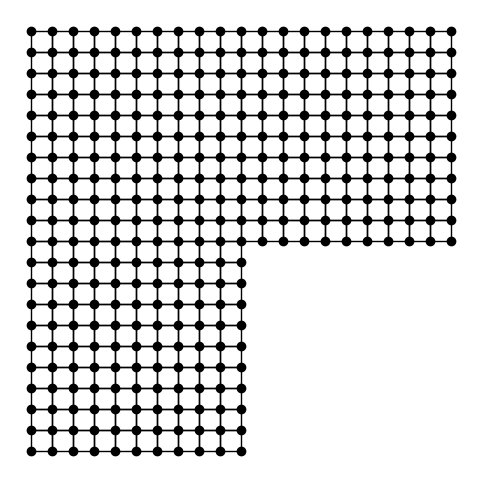

In [2]:
def create_connected_l_mesh(size=1.0, n_elements=20):
    """Create connected L-shaped mesh within [0,1] x [0,1] domain"""
    dx = size / n_elements

    # Create all unique nodes
    nodes = []
    node_dict = {}

    # Generate nodes for entire [0,1]x[0,1] domain, 
    # skipping lower-right quadrant
    for j in range(n_elements + 1):
        for i in range(n_elements + 1):
            x, y = i * dx, j * dx

            # Skip lower-right quadrant (x > 0.5 and y < 0.5)
            if x > size/2 and y < size/2:
                continue

            nodes.append([x, y])
            node_dict[(i, j)] = len(nodes) - 1

    # Create elements, skipping lower-right quadrant
    elements = []
    for j in range(n_elements):
        for i in range(n_elements):
            # Skip lower-right quadrant elements
            if i >= n_elements//2 and j < n_elements//2:
                continue

            # Get corner nodes
            corners = [(i, j), (i+1, j), (i+1, j+1), (i, j+1)]

            # Check if all corners exist
            if all((corner in node_dict) for corner in corners):
                element = [node_dict[corner] for corner in corners]
                elements.append(element)

    return torch.tensor(nodes), torch.tensor(elements)
# Create connected L-shaped mesh
nodes, elements = create_connected_l_mesh(size=2.0, n_elements=20)

# Create model
material = IsotropicElasticityPlaneStress(E=110000.0, nu=0.33)
model = Planar(nodes, elements, material)

# Visualize
model.plot(node_markers=True)

Increment 1 | Iteration 1 | Residual: 6.69986e+03
Increment 1 | Iteration 2 | Residual: 3.49616e+01
Increment 1 | Iteration 3 | Residual: 2.96192e-01
Increment 1 | Iteration 4 | Residual: 2.95080e-03
Increment 1 | Iteration 5 | Residual: 3.29372e-05


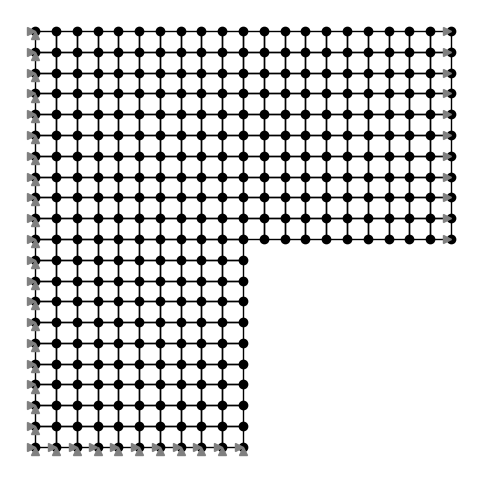

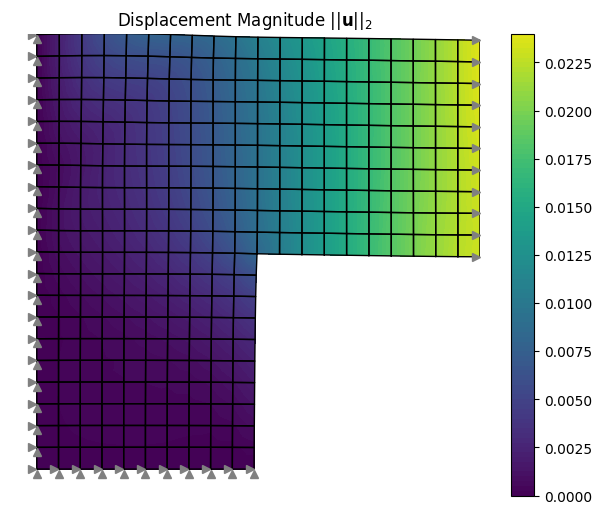

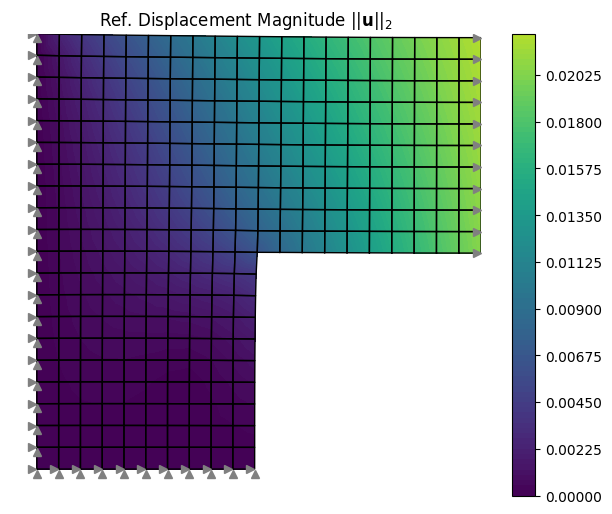

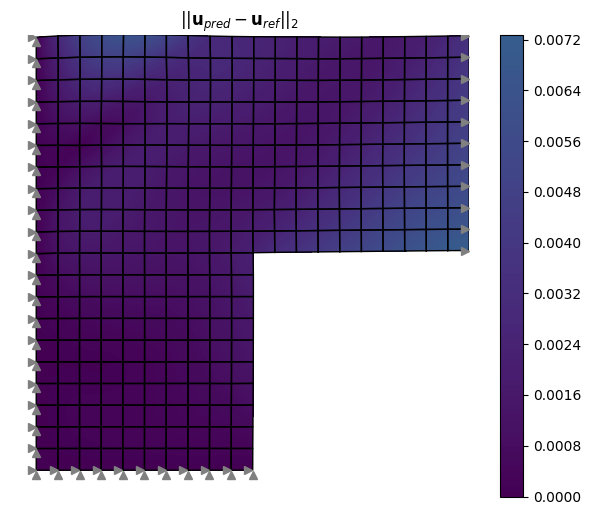

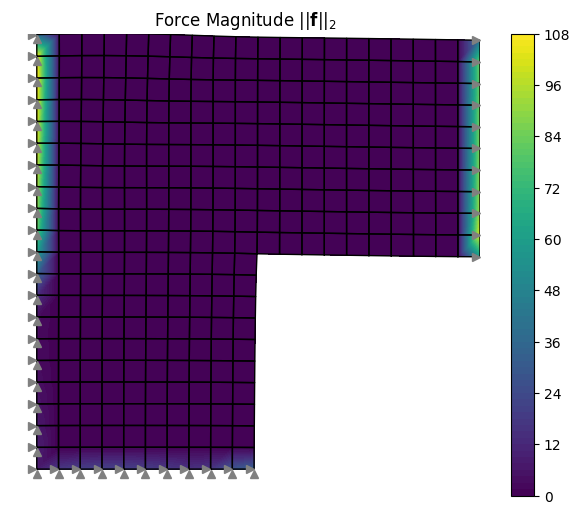

In [3]:
# Create L-shaped mesh within [0,1] x [0,1]
nodes, elements = create_connected_l_mesh(size=1.0, n_elements=20)

# Create model
material = IsotropicElasticityPlaneStrain(E=110000.0, nu=0.33)
model = Planar(nodes, elements, material)

# Set thickness
model.thickness[:] = 0.1

# Fix bottom edge (y = 0)
bottom_nodes = nodes[:, 1] == 0.0
model.constraints[bottom_nodes, :] = True

# Fix left edge (x = 0)  
left_nodes = nodes[:, 0] == 0.0
model.constraints[left_nodes, :] = True

# Apply displacement to right edge of top part (x = 1.0, y >= 0.5)
right_top_nodes = (nodes[:, 0] == 1.0) & (nodes[:, 1] >= 0.5)
model.displacements[right_top_nodes, 0] = 0.02
model.constraints[right_top_nodes, 0] = True

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Solve - reference configuration
increments = torch.linspace(0.0, 1.0, 2)
u_ref, f_ref, _, _, _ = model.solve(rtol=1e-12, atol=1e-7,
                                increments=increments)
# Solve with material patches
model_path = ("/Users/rbarreira/Desktop/machine_learning/"
                "material_patches/graphorge_material_patches/src/"
                "graphorge/projects/material_patches/elastic/2d/"
                "quad4/mesh1x1/ninc1/long_training_rnn/reference/3_model")
num_elements = elements.shape[0]
is_mat_patch = torch.arange(num_elements, dtype=torch.int)
increments = torch.linspace(0.0, 1.0, 2)
u, f, _, _, _ = model.solve_matpatch(
        is_mat_patch=is_mat_patch,
        increments=increments,
        max_iter=100,
        rtol=1e-8,
        atol=1e-7,
        verbose=True,
        return_intermediate=True,
        return_volumes=False,
        is_stepwise=False,
        model_directory=model_path)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Visualize
output_dir = 'results/elastic'
model.plot(node_markers=True)
plot_path = f"{output_dir}/l_shaped_1_mesh.png"
plt.savefig(plot_path, dpi=300)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Plot deformed configuration
# Surrogate model
model.plot(u=u[-1], node_property=torch.norm(u[-1], dim=1),
        title=r'Displacement Magnitude $||\mathbf{u}||_{2}$',
        colorbar=True, cmap='viridis', vmin=0.0, vmax=0.025)
plot_path = f"{output_dir}/l_shaped_2_disp_surrogate.png"
plt.savefig(plot_path, dpi=300)
# Reference solver
model.plot(u=u_ref[-1], node_property=torch.norm(u_ref[-1], dim=1),
        title=r'Ref. Displacement Magnitude $||\mathbf{u}||_{2}$',
        colorbar=True, cmap='viridis', vmin=0.0, vmax=0.025)
plot_path = f"{output_dir}/l_shaped_3_disp_reference.png"
plt.savefig(plot_path, dpi=300)
# Difference between surrogate model and reference displacements
u_diff = torch.abs(u[-1] - u_ref[-1]) 
model.plot(u=u_diff, node_property=torch.norm(u_diff, dim=1),
        title=r'$||\mathbf{u}_{pred} - \mathbf{u}_{ref}||_{2}$',
        colorbar=True, cmap='viridis', vmin=0.0, vmax=0.025)
plot_path = f"{output_dir}/l_shaped_4_difference.png"
plt.savefig(plot_path, dpi=300)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Plot force prediction
# Surrogate solver
model.plot(u=u[-1], node_property=torch.norm(f[-1], dim=1),
        title=r'Force Magnitude $||\mathbf{f}||_{2}$',
        colorbar=True, cmap='viridis')
plot_path = f"{output_dir}/l_shaped_5_force_surrogate.png"
plt.savefig(plot_path, dpi=300)

In [4]:
def create_unit_element_l_mesh(element_size=1.0, n_elements=20):
    """Create L-shaped mesh where each element has unit size"""

    # Total domain size is n_elements * element_size
    total_size = n_elements * element_size

    nodes = []
    node_dict = {}

    # Generate nodes with unit spacing
    for j in range(n_elements + 1):
        for i in range(n_elements + 1):
            x, y = i * element_size, j * element_size

            # Skip lower-right quadrant (x > total_size/2 and y < total_size/2)
            if x > total_size/2 and y < total_size/2:
                continue

            nodes.append([x, y])
            node_dict[(i, j)] = len(nodes) - 1

    # Create elements
    elements = []
    for j in range(n_elements):
        for i in range(n_elements):
            # Skip lower-right quadrant elements
            if i >= n_elements//2 and j < n_elements//2:
                continue

            corners = [(i, j), (i+1, j), (i+1, j+1), (i, j+1)]

            if all((corner in node_dict) for corner in corners):
                element = [node_dict[corner] for corner in corners]
                elements.append(element)

    return torch.tensor(nodes), torch.tensor(elements), total_size

# Create mesh with unit element size
nodes, elements, domain_size = create_unit_element_l_mesh(
    element_size=1.0, n_elements=20
)

print(f"Domain extends from (0,0) to ({domain_size},{domain_size})")
print(f"Each element has size {1.0} x {1.0}")

# Create model with updated domain
material = IsotropicElasticityPlaneStrain(E=110000.0, nu=0.33)
model = Planar(nodes, elements, material)
model.thickness[:] = 0.1

# Update boundary conditions for new domain size
bottom_nodes = nodes[:, 1] == 0.0
model.constraints[bottom_nodes, :] = True

left_nodes = nodes[:, 0] == 0.0
model.constraints[left_nodes, :] = True

right_top_nodes = ((nodes[:, 0] == domain_size) &
                    (nodes[:, 1] >= domain_size/2))
model.displacements[right_top_nodes, 0] = 2.0
model.constraints[right_top_nodes, 0] = True


# Solve
# u, f, σ, F, α = model.solve(rtol=1e-12)

# # Solve with material patches
model_path = ("/Users/rbarreira/Desktop/machine_learning/material_patches/"
              "graphorge_material_patches/src/graphorge/projects/"
              "material_patches/elastic/2d/quad4/mesh1x1/ninc1/"
              "scaler_minmax_rnn/reference/3_model")

num_elements = elements.shape[0]
is_mat_patch = torch.arange(num_elements, dtype=torch.int)
increments = torch.linspace(0.0, 1.0, 20)
u, f, σ, F, α = model.solve_matpatch(
        is_mat_patch=is_mat_patch,
        increments=increments,
        max_iter=150,
        rtol=1e-8,
        verbose=True,
        return_intermediate=True,
        return_volumes=False,
        is_stepwise=False,
        model_directory=model_path)

# Plot reference configuration
model.plot()
# Plot deformed configuration
model.plot(u=u[-1], node_property=torch.norm(u[-1], dim=1),
        title=r'Displacement Magnitude $||\mathbf{u}||_{2}$',
        colorbar=True,
        cmap='viridis')

model.plot(u=u[-1], node_property=torch.norm(f[-1], dim=1),
        title=r'Force Magnitude $||\mathbf{f}||_{2}$',
        colorbar=True,
        cmap='viridis')

Domain extends from (0,0) to (20.0,20.0)
Each element has size 1.0 x 1.0
Increment 1 | Iteration 1 | Residual: 4.07320e+04
Increment 1 | Iteration 2 | Residual: 5.87568e+03
Increment 1 | Iteration 3 | Residual: 9.79559e+03
Increment 1 | Iteration 4 | Residual: 1.10040e+04
Increment 1 | Iteration 5 | Residual: 8.77793e+03
Increment 1 | Iteration 6 | Residual: 2.94427e+03
Increment 1 | Iteration 7 | Residual: 3.60958e+03
Increment 1 | Iteration 8 | Residual: 4.25481e+03
Increment 1 | Iteration 9 | Residual: 3.73845e+03
Increment 1 | Iteration 10 | Residual: 2.35879e+03
Increment 1 | Iteration 11 | Residual: 1.32442e+03
Increment 1 | Iteration 12 | Residual: 1.30638e+03
Increment 1 | Iteration 13 | Residual: 1.47336e+03
Increment 1 | Iteration 14 | Residual: 9.86656e+02
Increment 1 | Iteration 15 | Residual: 9.30606e+02
Increment 1 | Iteration 16 | Residual: 6.96805e+02
Increment 1 | Iteration 17 | Residual: 4.44778e+02
Increment 1 | Iteration 18 | Residual: 5.61408e+02
Increment 1 | Iter

: 

# Dogbone

In [ ]:
def create_smooth_dogbone_mesh(length=10.0, gauge_width=2.0, grip_width=4.0, 
                            gauge_length=4.0, n_length=60, n_width=20):
    """Create 2D dogbone with smooth rounded transitions"""

    gauge_half = gauge_width / 2
    grip_half = grip_width / 2

    # Calculate transition zones
    transition_length = (length - gauge_length) / 2

    nodes = []
    x_coords = np.linspace(0, length, n_length + 1)

    for i, x in enumerate(x_coords):
        if x <= transition_length:
            # Left transition - smooth curve
            t = x / transition_length
            # Use cosine for smooth transition
            smooth_t = 0.5 * (1 - np.cos(np.pi * t))
            half_width = grip_half - smooth_t * (grip_half - gauge_half)

        elif x >= length - transition_length:
            # Right transition - smooth curve  
            t = (x - (length - transition_length)) / transition_length
            smooth_t = 0.5 * (1 - np.cos(np.pi * t))
            half_width = gauge_half + smooth_t * (grip_half - gauge_half)

        else:
            # Gauge section
            half_width = gauge_half

        # Create nodes across width
        y_coords = np.linspace(-half_width, half_width, n_width + 1)
        for y in y_coords:
            nodes.append([x, y])

    nodes = torch.tensor(nodes)

    # Create quad elements
    elements = []
    for i in range(n_length):
        for j in range(n_width):
            n1 = i * (n_width + 1) + j
            n2 = i * (n_width + 1) + j + 1
            n3 = (i + 1) * (n_width + 1) + j + 1
            n4 = (i + 1) * (n_width + 1) + j
            elements.append([n1, n2, n3, n4])

    return torch.tensor(nodes), torch.tensor(elements)

# Create smooth dogbone mesh
nodes, elements = create_smooth_dogbone_mesh(
    length=10.0, gauge_width=2.0, grip_width=4.0,
    gauge_length=4.0, n_length=60, n_width=20
)

# Create model
material = IsotropicElasticityPlaneStress(E=110000.0, nu=0.33)
model = Planar(nodes, elements, material)
model.thickness[:] = 0.1

# Boundary conditions
left_nodes = nodes[:, 0] == 0.0
model.constraints[left_nodes, :] = True

right_nodes = nodes[:, 0] == 10.0
model.displacements[right_nodes, 0] = 0.5
model.constraints[right_nodes, 0] = True




# Solve
u, f, σ, F, α = model.solve(rtol=1e-12)


# # Solve with material patches
# model_path = ("/Users/rbarreira/Desktop/machine_learning/material_patches/"
#               "graphorge_material_patches/src/graphorge/projects/"
#               "material_patches/elastic/2d/quad4/mesh1x1/ninc1/"
#               "long_training_rnn/reference/3_model")

# num_elements = elements.shape[0]
# is_mat_patch = torch.arange(num_elements, dtype=torch.int)
# increments = torch.linspace(0.0, 1.0, 2)
# u, f, σ, F, α = model.solve_matpatch(
#         is_mat_patch=is_mat_patch,
#         increments=increments,
#         max_iter=100,
#         rtol=1e-12,
#         verbose=True,
#         return_intermediate=True,
#         return_volumes=False,
#         is_stepwise=False,
#         model_directory=model_path)

# Plot reference configuration
model.plot()
# Plot deformed configuration
model.plot(u=u[-1], node_property=torch.norm(u[-1], dim=1),
        title=r'Displacement Magnitude $||\mathbf{u}||_{2}$',
        colorbar=True,
        cmap='viridis')

model.plot(u=u[-1], node_property=torch.norm(f[-1], dim=1),
        title=r'Force Magnitude $||\mathbf{f}||_{2}$',
        colorbar=True,
        cmap='viridis')